# I. 데이터 불러오기 및 확인

In [ ]:
import pandas as pd
import numpy as np

url = url = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/vgames2.csv'
data = pd.read_csv(url)
data.head()

,Unnamed: 0,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,1,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,2,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,4,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04


# # II. 데이터 전처리 & Feature Engineering

첫번째 열(Unnamed : 0)을 삭제

In [ ]:
data = data.iloc[:, 1:]
data.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04


Publisher(게임 제작 회사)는 중요한 feaeture가 아니므로 삭제

In [ ]:
data = data.drop(['Publisher'], axis = 1)
data.head()

,Name,Platform,Year,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,0.04,0,0,0
1,The Munchables,Wii,2009.0,Action,0.17,0,0,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,0,0,0.02,0
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,0.04,0,0,0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,0.12,0.09,0,0.04


결측치가 있는지 확인

In [ ]:
data.isnull().sum()
# Year, Genre에 결측치 존재

Name             0
Platform         0
Year           271
Genre           50
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

결측치 제거하고 잘 제거되었는지 확인

In [ ]:
data = data.dropna()
data.isnull().sum()
# 결측치가 잘 제거된 것을 확인

Name           0
Platform       0
Year           0
Genre          0
NA_Sales       0
EU_Sales       0
JP_Sales       0
Other_Sales    0
dtype: int64

출고량 데이터에서 K(Kilo = 1,000), M(Million = 1,000,000) 등 단위가 있는 값들은 단위 변환

In [ ]:
def toint(x) :
  if 'K' in x :
    return int(float(x.replace('K', ''))*1000)
  elif 'M' in x :
    return int(float(x.replace('M', ''))*1000000)
  else :
    return int(float(x)*1000000) # 판매수량이므로 최종 값을 integer로 출력

data['NA_Sales'] = data['NA_Sales'].apply(toint)
data['EU_Sales'] = data['EU_Sales'].apply(toint)
data['JP_Sales'] = data['JP_Sales'].apply(toint)
data['Other_Sales'] = data['Other_Sales'].apply(toint)

data.head()

,Name,Platform,Year,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,40000,0,0,0
1,The Munchables,Wii,2009.0,Action,170000,0,0,10000
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,0,0,20000,0
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,40000,0,0,0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,120000,90000,0,40000


출시연도 데이터 중  9, 97과 같은 값들을 2009, 1997과 같은 형태로 변환

In [ ]:
def toint2(x) : 
  if x < 50 :
    return int(x + 2000)
  elif x < 100 :
    return int(x + 1900)
  else :
    return int(x) # 연도이므로 최종 값을 integer로 출력

data['Year'] = data['Year'].apply(toint2)

data.head()

,Name,Platform,Year,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008,Action,40000,0,0,0
1,The Munchables,Wii,2009,Action,170000,0,0,10000
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,0,0,20000,0
3,Deal or No Deal: Special Edition,DS,2010,Misc,40000,0,0,0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,120000,90000,0,40000


연도에 따라 10년 단위로 데이터를 나누고 'Era'라는 새로운 feature를 생성

In [ ]:
# 출시연도가 가장 빠른 게임을 찾고 10년 단위로 연대를 나눈다
# data[data['Year'] > 1900]['Year'].sort_values() # 출시연도가 1980년부터 2020년까지의 데이터라는 것을 알 수 있다

def makeera(df, feature, x) :
  new_df = df[(df[feature] >= x) & (df[feature] < (x + 10))].copy()
  new_df['Era'] = x
  return new_df

data_80 = makeera(data, 'Year', 1980) # 204개
data_90 = makeera(data, 'Year', 1990) # 1764개
data_00 = makeera(data, 'Year', 2000) # 9153개
data_10 = makeera(data, 'Year', 2010) # 5119개
data_20 = makeera(data, 'Year', 2020) # 1개

# data_20은 샘플이 1개 밖에 없으므로 data_10과 병합
data_10 = pd.concat([data_10, data_20], axis = 0)

# 연도에 따라 나눈 데이터를 다시 병합
data_list = [data_80, data_90, data_00, data_10]
data2 = pd.concat(data_list, axis = 0)
data2 = data2.sort_index()

# Era라는 새로운 feature를 만들었으므로 Year 컬럼은 삭제

data2 = data2.drop(['Year'], axis = 1)

data2.head()

,Name,Platform,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Era
0,Candace Kane's Candy Factory,DS,Action,40000,0,0,0,2000
1,The Munchables,Wii,Action,170000,0,0,10000,2000
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,Adventure,0,0,20000,0,2010
3,Deal or No Deal: Special Edition,DS,Misc,40000,0,0,0,2010
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,Platform,120000,90000,0,40000,2010


모든 지역의 출고량을 합쳐서 'Total_Sales'라는 새로운 feature 생성

In [ ]:
data2['Total_Sales'] = data2['NA_Sales'] + data2['EU_Sales'] + data2['JP_Sales'] + data2['Other_Sales']
data2.head()

,Name,Platform,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Era,Total_Sales
0,Candace Kane's Candy Factory,DS,Action,40000,0,0,0,2000,40000
1,The Munchables,Wii,Action,170000,0,0,10000,2000,180000
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,Adventure,0,0,20000,0,2010,20000
3,Deal or No Deal: Special Edition,DS,Misc,40000,0,0,0,2010,40000
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,Platform,120000,90000,0,40000,2010,250000


컬럼들을 보기 편한 순서대로 재정렬

In [ ]:
data2 = data2[['Name', 'Platform', 'Genre', 'Era', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Total_Sales']]
data2.head()

,Name,Platform,Genre,Era,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
0,Candace Kane's Candy Factory,DS,Action,2000,40000,0,0,0,40000
1,The Munchables,Wii,Action,2000,170000,0,0,10000,180000
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,Adventure,2010,0,0,20000,0,20000
3,Deal or No Deal: Special Edition,DS,Misc,2010,40000,0,0,0,40000
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,Platform,2010,120000,90000,0,40000,250000


# III. 데이터 분석

**1. 출고량이 높은 게임에 대한 분석 및 시각화 프로세스**

총 출고량이 가장 높은 1000개의 데이터를 추출(플랫폼, 장르, 총 출고량)

In [ ]:
top = data2.sort_values('Total_Sales', ascending = False).head(1000)
top.head()

,Name,Platform,Genre,Era,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
2908,Wii Sports,Wii,Sports,2000,41490000,29020000,3770000,8460000,82740000
4199,Super Mario Bros.,NES,Platform,1980,29080000,3580000,6810000,770000,40240000
12579,Mario Kart Wii,Wii,Racing,2000,15850000,12880000,3790000,3310000,35830000
3352,Wii Sports Resort,Wii,Sports,2000,15750000,11010000,3280000,2960000,33000000
7829,Pokemon Red/Pokemon Blue,GB,Role-Playing,1990,11270000,8890000,10220000,1000000,31380000


가장 출고량이 높은 상위 5개의 플랫폼과 장르 확인

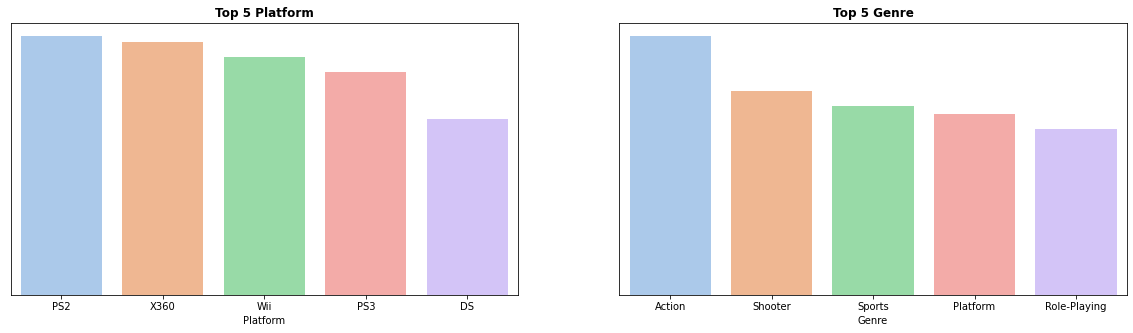

In [ ]:
top_platform = top.groupby(['Platform'])['Total_Sales'].sum().reset_index().sort_values('Total_Sales', ascending = False).head()
top_genre = top.groupby(['Genre'])['Total_Sales'].sum().reset_index().sort_values('Total_Sales', ascending = False).head()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (20, 5))

plt.subplot(121)
sns.barplot(x = 'Platform', y ='Total_Sales', data = top_platform, palette = 'pastel')
plt.title('Top 5 Platform', fontdict = {'fontweight' : 'bold'})
ax = plt.gca()
ax.axes.yaxis.set_visible(False)

plt.subplot(122)
sns.barplot(x = 'Genre', y ='Total_Sales', data = top_genre, palette = 'pastel')
plt.title('Top 5 Genre', fontdict = {'fontweight' : 'bold'})
ax = plt.gca()
ax.axes.yaxis.set_visible(False)

# PS2, X360, Wii, PS3, DS
# 액션, 슈팅, 스포츠, 플랫폼, 롤플레잉

Top 5 플랫폼과 장르의 조합만 추출

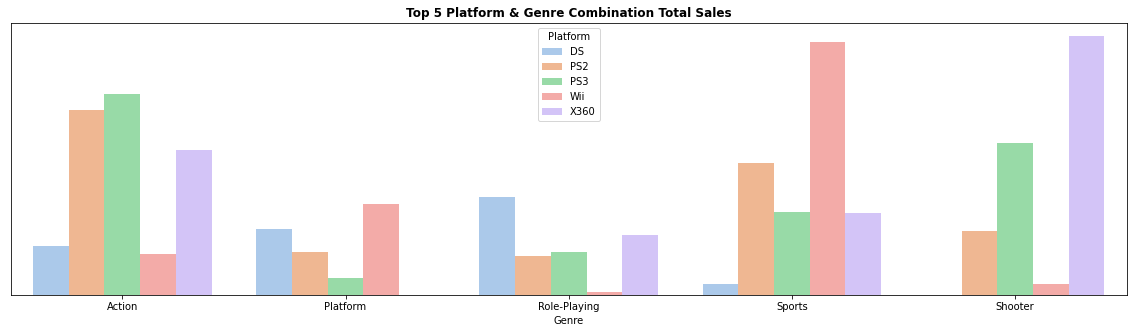

In [ ]:
plat = ['PS2', 'X360', 'Wii', 'PS3', 'DS']
gen = ['Action', 'Shooter', 'Sports', 'Platform', 'Role-Playing']

toptop = top[(top['Platform'].isin(plat)) & (top['Genre'].isin(gen))]
toptop_rank = toptop.groupby(['Platform', 'Genre'])['Total_Sales'].sum().reset_index()

plt.figure(figsize = (20, 5))
sns.barplot(x = 'Genre', y = 'Total_Sales', data = toptop_rank, hue = 'Platform', palette = 'pastel')
plt.title('Top 5 Platform & Genre Combination Total Sales', fontdict = {'fontweight' : 'bold'})
ax = plt.gca()
ax.axes.yaxis.set_visible(False)

1. 슈팅 - X360
2. 스포츠 - Wii
3. 액션 - PS3

각 시장별 규모 파악하기

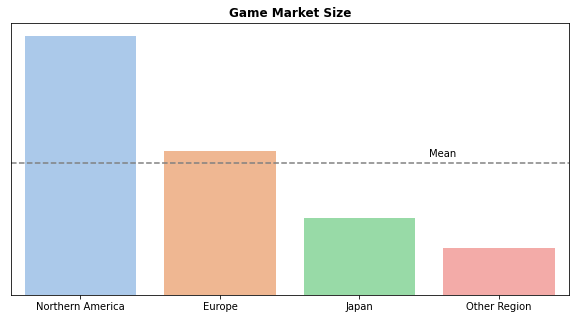

In [ ]:
NA_sum = data2['NA_Sales'].sum()
EU_sum = data2['EU_Sales'].sum()
JP_sum = data2['JP_Sales'].sum()
Other_sum = data2['Other_Sales'].sum()

Total_mean = (data2['Total_Sales'].sum()) / 4

x = ['Northern America', 'Europe', 'Japan', 'Other Region']
y = [NA_sum, EU_sum, JP_sum, Other_sum]

plt.figure(figsize = (10, 5))
sns.barplot(x = x, y= y, palette = 'pastel')
plt.title('Game Market Size', fontdict = {'fontweight' : 'bold'})
plt.axhline(y = Total_mean, linestyle = '--', color = 'grey')
plt.text(2.5, Total_mean + 100000000, 'Mean')
ax = plt.gca()
ax.axes.yaxis.set_visible(False)

북미 시장이 압도적으로 큰 것을 알 수 있다

즉, 특정 시장을 노린다면 시장 규모가 큰 북미 시장을 노리는 것이 좋다고 할 수 있다

**2. 지역에 따라 선호되는 게임의 플랫폼과 장르 확인**

지역에 따라 선호되는 게임의 플랫폼 확인

In [ ]:
# 지역별로 출고량이 높은 게임 플랫폼 상위 5개를 정리
def region_platform(df, country) :
  x = df.groupby('Platform').sum()[country]
  x = x.reset_index()
  x = x.sort_values(country, ascending = False).head()
  return x

platform_top_NA = region_platform(data2, 'NA_Sales')
platform_top_EU = region_platform(data2, 'EU_Sales')
platform_top_JP = region_platform(data2, 'JP_Sales')
platform_top_Other = region_platform(data2, 'Other_Sales')

platform_top_NA

,Platform,NA_Sales
28,X360,593779998
16,PS2,568539995
26,Wii,495099999
17,PS3,387999999
4,DS,387960000


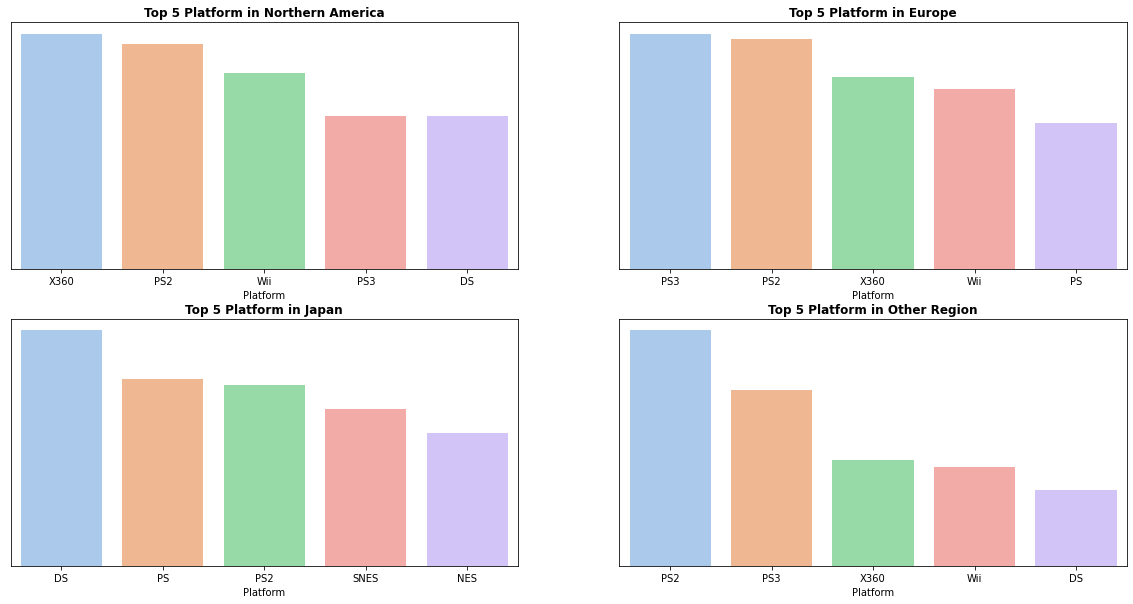

In [ ]:
def platform_rank(df, country, pos, title) :
  plt.subplot(pos)
  sns.barplot(x = 'Platform', y = country, data = df, palette = 'pastel')
  plt.title(title, fontdict = {'fontweight' : 'bold'})
  ax = plt.gca()
  ax.axes.yaxis.set_visible(False)

plt.figure(figsize = (20, 10))

platform_rank(platform_top_NA, 'NA_Sales', 221, 'Top 5 Platform in Northern America')
platform_rank(platform_top_EU, 'EU_Sales', 222, 'Top 5 Platform in Europe')
platform_rank(platform_top_JP, 'JP_Sales', 223, 'Top 5 Platform in Japan')
platform_rank(platform_top_Other, 'Other_Sales', 224, 'Top 5 Platform in Other Region')

출고량 상위 1000개 게임 기준으로 플랫폼 점유 순위 : PS2, X360, Wii, PS3, DS
*   북미지역 top 5 : X360, PS2, Wii, PS3, DS
*   유럽지역 top 5 : PS3, PS2, X360, Wii, PS
*   일본지역 top 5 : DS, PS, PS2, SNES, NES
*   기타지역 top 5 : PS2, PS3, X360, Wii, DS

지역에 따라 선호되는 게임의 장르를 확인

In [ ]:
# 지역별로 출고량이 높은 게임 플랫폼 상위 5개를 정리
def region_genre(df, country) :
  x = df.groupby('Genre').sum()[country]
  x = x.reset_index()
  x = x.sort_values(country, ascending = False).head()
  return x

genre_top_NA = region_genre(data2, 'NA_Sales')
genre_top_EU = region_genre(data2, 'EU_Sales')
genre_top_JP = region_genre(data2, 'JP_Sales')
genre_top_Other = region_genre(data2, 'Other_Sales')

genre_top_NA

,Genre,NA_Sales
0,Action,858779997
10,Sports,667259996
8,Shooter,574479997
4,Platform,445379999
3,Misc,400289999


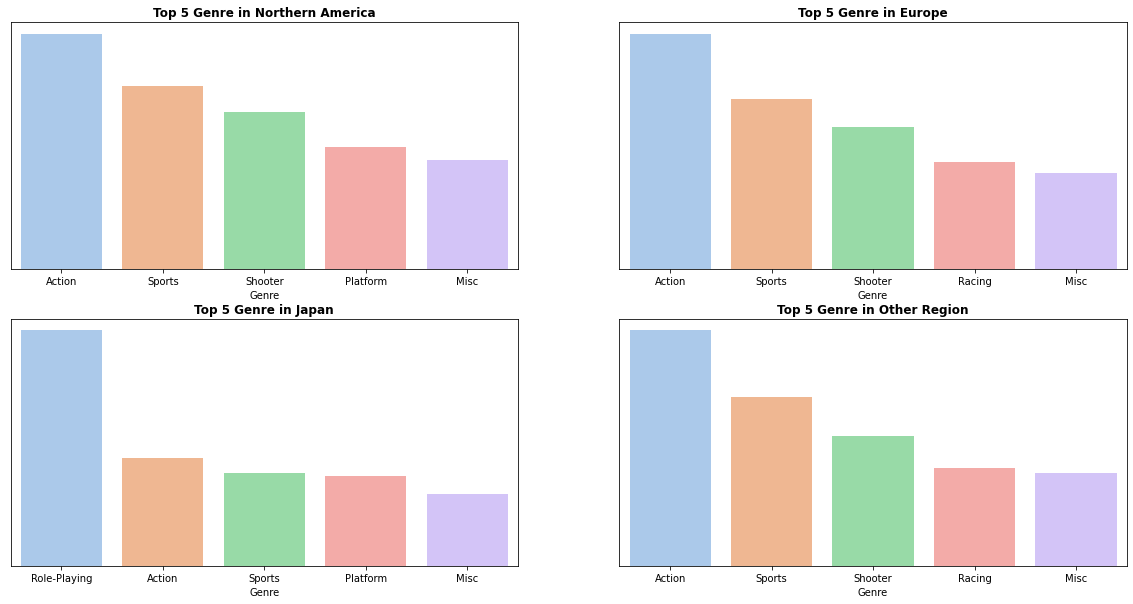

In [ ]:
def genre_rank(df, country, pos, title) :
  plt.subplot(pos)
  sns.barplot(x = 'Genre', y = country, data = df, palette = 'pastel')
  plt.title(title, fontdict = {'fontweight' : 'bold'})
  ax = plt.gca()
  ax.axes.yaxis.set_visible(False)

plt.figure(figsize = (20, 10))

genre_rank(genre_top_NA, 'NA_Sales', 221, 'Top 5 Genre in Northern America')
genre_rank(genre_top_EU, 'EU_Sales', 222, 'Top 5 Genre in Europe')
genre_rank(genre_top_JP, 'JP_Sales', 223, 'Top 5 Genre in Japan')
genre_rank(genre_top_Other, 'Other_Sales', 224, 'Top 5 Genre in Other Region')

출고량 상위 1000개 게임 기준으로 플랫폼 점유 순위 : 액션, 슈팅, 스포츠, 플랫폼, 롤플레잉
*   북미지역 top 5 : 액션, 스포츠, 슈팅, 플랫폼, Misc
*   유럽지역 top 5 : 액션, 스포츠, 슈팅, 레이싱, Misc
*   일본지역 top 5 : 롤플레잉, 액션, 스포츠, 플랫폼, Misc
*   기타지역 top 5 : 액션, 스포츠, 슈팅, 레이싱, Misc

*1.에서 얻은 결과로 X360 플랫폼에서 구동되는 슈팅 게임을 제작한다고 했을 때,
플랫폼 점유 순위가 1위이며, 장르 점유 순위가 3위인 북미 시장에서 충분히 경쟁력을 가질 수 있다!*

**2. 연도별 게임의 플랫폼과 장르 확인**

*   출고량 상위 1000개 게임 기준으로 플랫폼 점유 순위 : PS2, X360, Wii, PS3, DS
*   출고량 상위 1000개 게임 기준으로 플랫폼 점유 순위 : 액션, 슈팅, 스포츠, 플랫폼, 롤플레잉


을 이용하여 연도별로 제작된 게임의 트렌드 추이를 살펴볼 수 있다

상위 5개의 플랫폼의 연대별 제작 게임 수를 파악

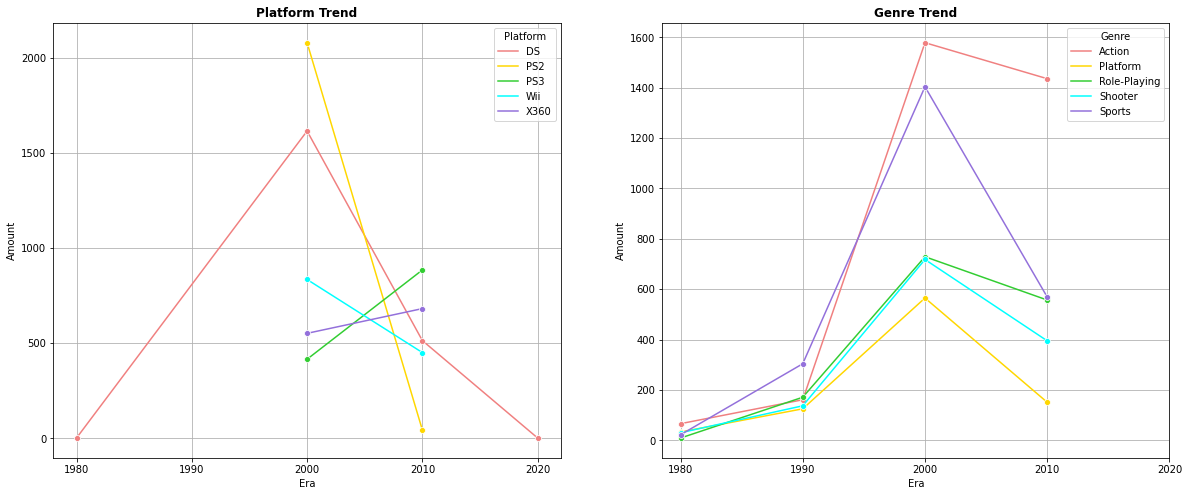

In [ ]:
# plat = ['PS2', 'X360', 'Wii', 'PS3', 'DS']
# gen = ['Action', 'Shooter', 'Sports', 'Platform', 'Role-Playing']

trend_plat = data2[data2['Platform'].isin(plat)]
trend_plat_era = trend_plat.groupby(['Platform', 'Era']).size().reset_index()
trend_plat_era.columns = ['Platform', 'Era', 'Amount']

trend_gen = data2[data2['Genre'].isin(gen)]
trend_gen_era = trend_gen.groupby(['Genre', 'Era']).size().reset_index()
trend_gen_era.columns = ['Genre', 'Era', 'Amount']

plt.figure(figsize = (20, 8))

colormap = ['lightcoral', 'gold', 'limegreen', 'aqua', 'mediumpurple']

plt.subplot(121)
sns.lineplot(x= 'Era', y = 'Amount', data = trend_plat_era, hue = 'Platform', 
             marker = 'o', palette = colormap)
plt.xticks([1980, 1990, 2000, 2010, 2020])
plt.title('Platform Trend', fontdict = {'fontweight' : 'bold'})
plt.grid(True)

plt.subplot(122)
sns.lineplot(x= 'Era', y = 'Amount', data = trend_gen_era, hue = 'Genre', 
             marker = 'o', palette = colormap)
plt.xticks([1980, 1990, 2000, 2010, 2020])
plt.title('Genre Trend', fontdict = {'fontweight' : 'bold'})
plt.grid(True)

*   X360 플랫폼은 2000년대에 처음 등장해서 다른 플랫폼에 비해 2010년대에 더 많은 수의 게임이 제작되었으며, 증가의 폭도 가장 큰 편
*   슈팅 게임의 경우는 2010년대 들어서 제작 게임의 수가 하락하긴 했으나 스포츠, 플랫폼 같은 장르에 비해서는 감소의 폭이 다소 적은 편

*따라서 연대별 트렌드를 고려했을 때 X360 플랫폼 기반의 슈팅 게임을 제작하는 것은 좋은 결정이라고 판단*

# IV. 가설 생성 및 검정

X360 플랫폼의 슈팅 게임을 제작하는 것으로 결정하였으므로 가설 검정을 하기 위해 X360 플랫폼의 슈팅 게임 데이터와 나머지 데이터를 분리

In [ ]:
x360_shoot = data2[(data2['Platform'] == 'X360') & (data2['Genre'] == 'Shooter')]
index = x360_shoot.index # x360 플랫폼의 슈팅 게임 데이터 삭제를 위해 index를 추출

other = data2.drop(index) # x360 플랫폼의 슈팅 게임 인덱스 데이터를 삭제

x360_shoot

,Name,Platform,Genre,Era,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
32,Project Sylpheed: Arc of Deception,X360,Shooter,2000,120000,10000,20000,10000,160000
44,Crysis 3,X360,Shooter,2010,510000,330000,10000,80000,930000
61,Unreal Tournament III,X360,Shooter,2000,250000,170000,10000,50000,480000
122,Call of Duty 4: Modern Warfare,X360,Shooter,2000,5910000,2380000,130000,900000,9320000
192,Left 4 Dead 2,X360,Shooter,2000,2670000,890000,50000,370000,3980000
...,...,...,...,...,...,...,...,...,...
16218,James Bond 007: Legends,X360,Shooter,2010,130000,140000,0,30000,300000
16227,Battlefield: Bad Company 2,X360,Shooter,2010,2089999,1020000,40000,320000,3469999
16235,Mercenaries 2: World in Flames,X360,Shooter,2000,650000,300000,10000,100000,1060000
16259,SpongeBob SquarePants: Plankton's Robotic Revenge,X360,Shooter,2010,40000,0,0,0,40000


**1. X360 플랫폼의 슈팅 게임이 다른 게임들의 출고량보다 평균이 높다**

*   귀무가설(H0) : X360 플랫폼의 슈팅 게임의 출고량 평균은 다른 게임들의 출고량의 평균과 같다
*   대립가설(H1) : X360 플랫폼의 슈팅 게임의 출고량 평균은 다름 게임들의 출고량의 평균보다 높다



In [ ]:
!pip install scipy --upgrade

In [ ]:
from scipy import stats

sales1 = x360_shoot['Total_Sales']
sales2 = other['Total_Sales']

stats.ttest_ind(sales1, sales2, alternative = 'greater')

Ttest_indResult(statistic=7.863954031269969, pvalue=1.9769974741092913e-15)

pvalue가 매우 작은 값이므로 귀무가설을 기각, X360 플랫폼의 슈팅 게임의 출고량 평균이 더 높다는 것을 알 수 있다

**2. X360 플랫폼의 슈팅 게임이 다른 게임들의 북미 시장 출고량보다 평균이 높다**

*   귀무가설(H0) : X360 플랫폼의 슈팅 게임의 북미 시장 출고량 평균은 다른 게임들의 북미 시장 출고량의 평균과 같다
*   대립가설(H1) : X360 플랫폼의 슈팅 게임의 북미 시장 출고량 평균은 다름 게임들의 북미 시장 출고량의 평균보다 높다

In [ ]:
sales3 = x360_shoot['NA_Sales']
sales4 = other['NA_Sales']

stats.ttest_ind(sales3, sales4, alternative = 'greater')

Ttest_indResult(statistic=10.608235639100876, pvalue=1.6614419391143146e-26)

pvalue가 매우 작은 값이므로 귀무가설을 기각, X360 플랫폼의 슈팅 게임의 북미 시장 출고량 평균이 더 높다는 것을 알 수 있다

# V. 결론

**데이터 분석 단계에서 X360 기반 슈팅 게임이 시장 규모가 가장 큰 북미지역 뿐 아니라 일본을 제외한 다른 지역에서도 판매량이 높을 것이라고 예상되었고, 현재 게임의 트렌드에도 적합하다고 판단함. 그리고 이는 두 가지 가설을 검정함으로써 증명됨.**


*   결론 : 다음 분기에 X360 기반 슈팅 게임을 설계를 해야 한다.

